# I) Construction des solutions exactes en 1D et 2D
On connait les solutions exactes de l'oscillateur harmonique 1D et 2D:
Pour le hamiltonien $\mathcal{H} = -\frac{\hbar^2}{2m} \frac{\partial^2}{\partial x^2} + \frac{1}{2} m \omega^2 x^2$, les valeurs propres sont $E_n = (n+\frac{1}{2}) \hbar \omega$ et les vecteurs propres $\phi_n(x) = (\frac{m\omega}{\hbar})^{1/4} 2^{-n/2} n!^{-1/2} \pi^{-1/4} H_n(\sqrt{\frac{m\omega}{\hbar}}x) \exp (-\frac{m\omega}{2\hbar}x^2)$ avec $H_n$ le $n$-ième polynôme de Hermite de forme dite physique (et pas la forme probabiliste).



Pour le hamiltonien 2D, on prend $\mathcal{H} = -\frac{\hbar^2}{2m} (\frac{\partial^2}{\partial x^2} + \frac{\partial^2}{\partial y^2})+ \frac{1}{2} m \omega^2 (x^2+y^2)$, on peut séparer les variables, trouver une solution sous la forme $\phi(x,y)= X(x)Y(y)$ où $X$, $Y$, sont chacun solutions d'un oscillateur harmonique 1D d'énergie quantifiée respective $E_x$ et $E_y$, ce qui mène à $E_{n_x,n_y} = E_{n_x}+E_{n_y}$ et $\phi_{n_x,n_y} = \phi_{n_x}(x)\phi_{n_y}(y)$ Une source intéressante: https://ocw.nctu.edu.tw/upload/classbfs120904402944051.pdf

In [1]:
using Polynomials, SpecialPolynomials
const SP=SpecialPolynomials
x = variable(Polynomial{Rational{Int}})
H = [SP.basis(Hermite, i)(x) for i in 0:20] # /!\ au décalage d'incice
ϕ1D = (n,x) -> (𝓂*ω/ħ)^(.25)*2^(-n/2)*1/sqrt(factorial(n))*pi^(-1/4)*H[n+1](sqrt(𝓂*ω/ħ)*x)*exp(-𝓂*ω/2/ħ*x^2)
ϕ2D = (nₖ, nₗ, x, y) -> sqrt(𝓂*ω/ħ)/sqrt(2^(nₖ+nₗ))/sqrt(factorial(nₖ)*factorial(nₗ))/sqrt(pi) * H[nₖ+1](sqrt(𝓂*ω/ħ)*x) * H[nₗ+1](sqrt(𝓂*ω/ħ)*y) * exp(-𝓂*ω/2/ħ*(x^2+y^2)) # redéfinition pour éviter trop de calculs

#13 (generic function with 1 method)

## EN 2D

In [2]:
using LinearAlgebra
using SparseArrays

function create_laplacian_2D(N,Δx²,Δy²) 
    N² = N*N;
    # BLOC EXTRADIAGONAL
    J = 1/Δy²*sparse(I,N,N);  # précédemment Matrix{Float64}(I, N,N);

    # BLOC DIAGONAL
    diag = -2*(1/Δx²+1/Δy²)*ones(Float64,N);             # vecteur de la diagonale
    extra_diag = 1/Δx²*ones(Float64,N-1);        # vecteur de la sur- et sous-diagonale remplies de 1

    H = Tridiagonal(extra_diag, diag, extra_diag); # matrice des blocs diagonaux, qui est tridiagonale, ne pas mettre sparse, cf benchmark ci dessous

    # MATRICE COMPLÈTE
    Λ = spzeros(N²,N²); # précédemment Matrix{Float64}(I,N*N,N*N)
    for i in 1:N
        @. Λ[1+(i-1)*N:i*N,1+(i-1)*N:i*N] = H[:,:]
    end

    for i in 1:N-1 # remplissages simultanés blocs extra diagonaux
        @. Λ[1+(i-1)* N : i    *N, 1+(i)  *N :  (i+1)*N] = J[:,:] # remplissage blocs extradiag supérieurs
        @. Λ[1+(i)  * N : (i+1)*N, 1+(i-1)*N :      i*N] = J[:,:] # remplissage blocs extradiag inférieurs
    end
    Λ
end

function create_potential_2D(xmin, ymin, Nx, Ny, δx, δy, V_fun)
    V = Diagonal(reshape([V_fun(xmin+i*δx,ymin+j*δy) for i=0:Nx-1, j=0:Ny-1],Nx*Ny)) # c'est toujours mieux optimisé et plus rapide que de créer soi-même 
end

function create_potential_2D_mod(xmin, ymin, Nx, Ny, δx, δy, V_fun)
    V = Diagonal([V_fun(xmin+(i%Nx)*δx,ymin+(i÷Ny)*δy) for i=0:Nx*Ny-1])
end

function hamiltonian_2D(xmin, xmax, ymin, ymax, Nx, Ny, V_fun, 𝓂, ħ)
    Δx = (xmax-xmin)/Nx;
    Δy = (ymax-ymin)/Ny;
    Λ = create_laplacian_2D(Nx,Δx*Δx,Δy*Δy);
    𝒱 = create_potential_2D(xmin, ymin, Nx, Ny, Δx, Δy, V_fun);
    ℋ = -ħ^2/2/𝓂*Λ+𝒱;
    ℋ,𝒱,Λ
end

hamiltonian_2D (generic function with 1 method)

In [4]:
xmin=-6; xmax=6; ymin=-6; ymax=6; Nx=100; Ny=100; 𝓂=1; ω=1; ħ=1; V_fun = (x,y) -> 1/2*𝓂*ω*(x^2+y^2); 

using KrylovKit

ℋ,𝒱,Λ =  hamiltonian_2D(xmin, xmax, ymin, ymax, Nx, Ny, V_fun, 𝓂, ħ);
typeof(ℋ), issymmetric(ℋ), ishermitian(ℋ), isposdef(ℋ)
# on aurait donc intérêt à utiliser les types correspondants dans Julia
# des routines pour les éléments propres existent cf https://docs.julialang.org/en/v1/stdlib/LinearAlgebra/#Matrix-factorizations
# mais les tests montrent que les méthodes eigvals et eigvecs ne sont pas vraiment plus rapides sur les types Hermitian(ℋ) et Symmetric(ℋ) (quasi les mêmes temps)

# trop lent: on utilise Krylov surtout que les derniers vecteurs propres n'ont plus aucun sens physique à cause de la taille limitée de la grille
# @time vap = eigvals(ℋ);
# @time vep = eigvecs(ℋ); 

x₀ =  rand(Float64, Nx*Ny);
@time vap, vep, info = KrylovKit.eigsolve(sparse(ℋ), x₀, 100, :SR, krylovdim=200);
info.converged

  3.211985 seconds (23.19 k allocations: 393.627 MiB, 1.44% gc time)


105

#### tracé des valeurs calculées numériquement

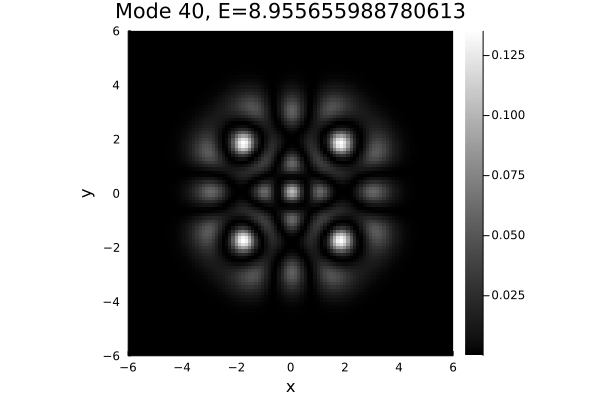

In [8]:
using Colors, Plots
mode = 40;
heatmap(LinRange(xmin,xmax,Nx),LinRange(ymin,ymax,Ny), reshape(Nx/(xmax-xmin)*Ny/(ymax-ymin)*abs.(vep[mode+1]).^2,Nx,Ny) , xlabel="x", ylabel="y",xlims = (xmin,xmax), ylims=(ymin,ymax),color=:greys, aspect_ratio=:equal ,title = "Mode $(mode), E=$(vap[mode+1])")

#### tracé des valeurs théoriques par séparation des variables
cf calcul précédent. Mais la solution en variables séparées ne permet pas d'expliquer tous les états propres elliptiques observés pour les grands nombres $n_k$ et $n_l$

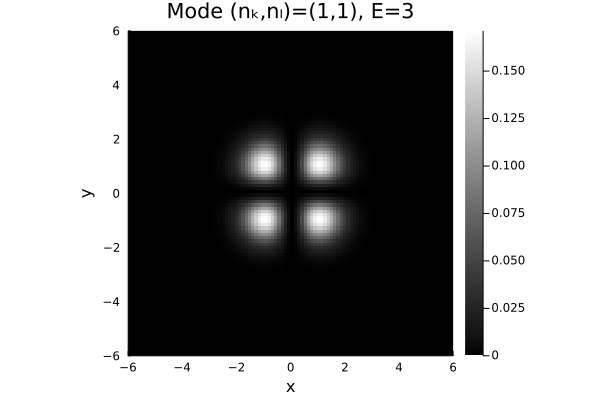

In [15]:
nₖ=1; nₗ=1; Δx=(xmax-xmin)/Nx; Δy=(ymax-ymin)/Ny;
# pour une grille 70 × 70: (2,2) -> 14; (3,3) -> 27; (4,4) -> 44;   (5,5) -> 65; (7,7) -> 105
# pour une grille 100 × 100: (2,3) -> 20; (,) -> 5;
heatmap(LinRange(xmin,xmax,Nx),LinRange(ymin,ymax,Ny), transpose([ϕ2D(nₖ, nₗ, xmin+i*Δx, ymin+j*Δy)^2 for i=0:Nx-1, j=0:Ny-1]), xlabel="x", ylabel="y",xlims = (xmin,xmax), ylims=(ymin,ymax),color=:greys, aspect_ratio=:equal ,title = "Mode (nₖ,nₗ)=($nₖ,$nₗ), E=$(1+nₖ+nₗ)")

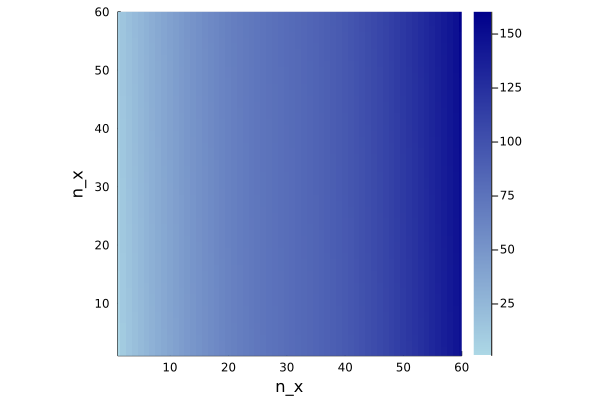

In [381]:
heatmap(LinRange(1,Nx,Nx),LinRange(1,Ny,Ny), reshape(vap,Nx,Ny), xlabel="n_x", ylabel="n_x",xlims = (1,Nx), ylims=(1,Ny),color=:blues, aspect_ratio=:equal)

## En 1D

In [16]:
using LinearAlgebra
using SparseArrays

function create_laplacian_1D(N,Δx²)
    1/Δx²*SymTridiagonal(-2*ones(Float64,N),ones(Float64,N-1))
end

function create_potential_1D(xmin, xmax, N, V_fun)
    Diagonal(V_fun.(LinRange(xmin,xmax,N)))
end

function hamiltonian_1D(xmin, xmax, N, V_fun, 𝓂, ħ)
    Δx = (xmax-xmin)/N;
    Λ = create_laplacian_1D(N,Δx*Δx);
    𝒱 = create_potential_1D(xmin, xmax, N, V_fun);
    ℋ = -ħ^2/2/𝓂*Λ+𝒱;
    ℋ,𝒱,Λ # renvoyer le terme 
end

hamiltonian_1D (generic function with 1 method)

On plot ensuite la solution théorique exacte $|\psi|^2$ que l'on calcule, de l'oscillateur harmonique 1D, ainsi que la solution approchée $|\hat{\psi}|^2$ qui consiste en un ensemble de point. A chaque point de discrétisation $x_i$ est associée une valeur de $|\hat{\psi}_i|^2$ qui représente la densité de probabilité discrète dans l'espace de Hilbert de dimension finie associé au problème. Pour faire le plot, on doit normaliser cette valeur pour que l'affichage soit correct, i.e. multiplier par la longueur de l'intervalle pour compenser l'écrasement des $|\hat{\psi}_i|^2$ dû à l'augmentation du nombre de points. Plus $N$ est grand, plus la solution numérique est proche de la solution exacte.

  0.002031 seconds (4 allocations: 12.938 KiB)
  0.009844 seconds (12 allocations: 1.325 MiB)


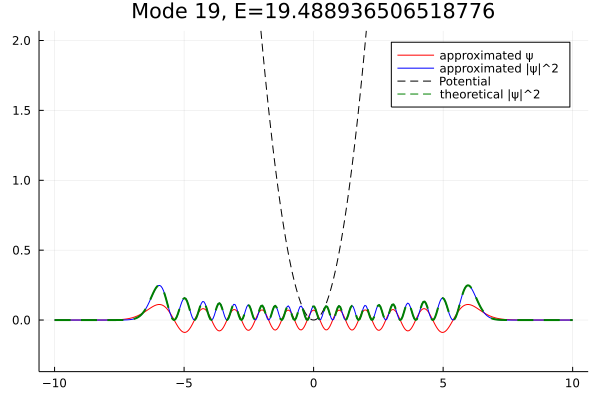

In [20]:
using Plots
using LaTeXStrings
xmin=-10; xmax=10; N=400; 𝓂=1; ω=1; ħ=1; V_fun = x->1/2*𝓂*ω*x^2; Δx = (xmax-xmin)/N;
ℋ,𝒱,Λ = hamiltonian_1D(xmin, xmax, N, V_fun, 𝓂, ħ);

@time vap = eigvals(ℋ);
@time vep = eigvecs(ℋ); # ils sont normés

nₓ = 20; # nombre quantique
axis_range = LinRange(xmin,xmax,N);
plot(axis_range, [vep[:,nₓ+1], N/(xmax-xmin)*abs.(vep[:,nₓ+1]).^2, V_fun.(axis_range), ϕ1D.(nₓ,axis_range).^2], ylim=[-.3, 2], grid=true, w=[1 1 1 2], color = ["red" "blue" "black" "green"], linestyle=[:solid :solid :dash :dash], label=["approximated ψ" "approximated |ψ|^2" "Potential" "theoretical |ψ|^2"], title = "Mode $(nₓ-1), E=$(vap[nₓ])")

In [17]:
function fundamental_state(xmin,xmax,N,V_fun,𝓂)
    
end

fundamental_state (generic function with 1 method)

# II) [discontinued] Tests et prototypage

In [289]:
# en analyse numérique: que vaut-il mieux faire lorsqu'on a beaucoup de facteurs grands et petits qui se compensent ?
n = 15; 
@btime 2^(-n/2)
@btime 1/sqrt(2^n)

  94.969 ns (2 allocations: 32 bytes)
  65.682 ns (3 allocations: 48 bytes)


0.005524271728019902

###  A présent, avec KrylovKit (plus rapide)
Exemple avec une grille de 70 par 70: là où les commandes `@time vap = eigvals(ℋ);` et `@time vep = eigvecs(ℋ);` prenaient 11 et 25 secondes environ, Krylov en obtient ici 91 avec une précision très bonne pour seulement 22 secondes.

In [11]:
using SparseArrays
xmin=-5; xmax=5; ymin=-5; ymax=5; Nx=100; Ny=100; 𝓂=1; ω=1; ħ=1; V_fun = (x,y) -> 1/2*𝓂*ω*(x^2+y^2); 
ℋ,𝒱,Λ =  hamiltonian_2D(xmin, xmax, ymin, ymax, Nx, Ny, V_fun, 𝓂, ħ);

using KrylovKit
x₀ =  rand(Float64, Nx*Ny);
@time vals, vecs, info = KrylovKit.eigsolve(sparse(ℋ), x₀, 10, :SR, krylovdim=15);

  0.494198 seconds (7.14 k allocations: 117.791 MiB, 36.32% gc time)


In [220]:
info

ConvergenceInfo: 118 converged values after 28 iterations and 1930 applications of the linear map;
norms of residuals are given by (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.6913946648850265e-139, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.1590908953714066e-27, 9.031608375444724e-29, 0.0, 6.990177041908623e-30, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.5200490488398675e-23, 3.378998364668534e-20, 6.475050494355465e-19, 9.40670322945011e-22, 5.765262684917077e-23, 3.426916648816087e-20, 8.354437939556669e-24, 2.3275780461916083e-22, 1.2309429168739025e-25, 1.9884046057447426e-23, 2.3628891774548744e-26, 1.8752707011449782e-23, 1.338453854730271e-24, 2.9253026511220494e-24, 0.0, 8.370

In [ ]:
(evals, evecs) = eigen(Symmetric(A), 1:r)

In [193]:
norm(vals[1:info.converged] - vap[1:info.converged])
norm(vecs[6] - vep[:,6])

1.9999999999999996

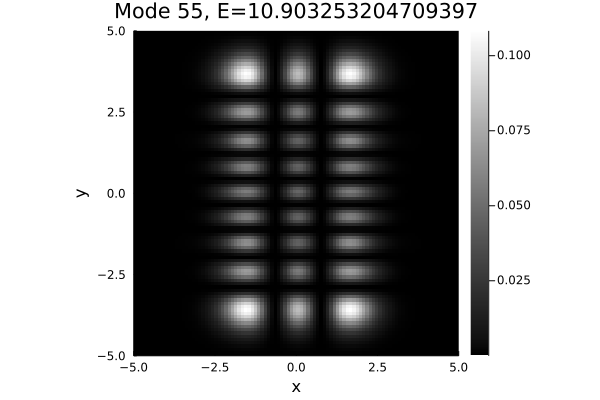

In [256]:
using Colors, Plots
mode = 55;
heatmap(LinRange(xmin,xmax,Nx),LinRange(ymin,ymax,Ny), reshape(Nx/(xmax-xmin)*Ny/(ymax-ymin)*abs.(vecs[mode+1]).^2,Nx,Ny) , xlabel="x", ylabel="y",xlims = (xmin,xmax), ylims=(ymin,ymax),color=:greys, aspect_ratio=:equal ,title = "Mode $(mode), E=$(vap[mode+1])")

In [206]:
norm(normalize(vep[:,1])+normalize(vecs[1])) # les deux vecteurs normalisés, trouvés par les deux méthodes ont une norme proche à 14 petits ordres de grandeur près

1.821424043684196e-14

### Vaut-il mieux utilier le type sparse après la tridiagonale ou pas ?

In [11]:
using LinearAlgebra
using SparseArrays

avec_sparse = N -> sparse(Tridiagonal([1.0 for i in 1:N-1],[-2.0 for i in 1:N],[1.0 for i in 1:N-1]));
sans_sparse = N ->        Tridiagonal([1.0 for i in 1:N-1],[-2.0 for i in 1:N],[1.0 for i in 1:N-1]);
r = @time avec_sparse(200);
t = @time sans_sparse(200);

sizeof(r), sizeof(t)

  0.077721 seconds (264.63 k allocations: 14.065 MiB, 99.96% compilation time)
  0.055280 seconds (212.54 k allocations: 11.217 MiB, 99.96% compilation time)


(40, 32)

In [27]:
function essai1(N)
    SymTridiagonal(-2*ones(Float64,N),ones(Float64,N-1))
end

function essai2(N)
    diag = -2*ones(Float64,N);
    extra_diag = ones(Float64,N-1);
    SymTridiagonal(diag,extra_diag)
end

essai3 = N -> SymTridiagonal(-2*ones(Float64,N),ones(Float64,N-1));

In [29]:
r = @time essai1(200);
t = @time essai2(200);
u = @time essai2(200);

  0.000015 seconds (3 allocations: 5.297 KiB)
  0.000006 seconds (3 allocations: 5.297 KiB)
  0.000014 seconds (3 allocations: 5.297 KiB)


### Comparer les méthodes de remplissage de la grille avec le potentiel

In [ ]:
ymin = -5.;
ymax = 5.;
xmin = -2.;
xmax = 3.;
N = 5;
Δy = (ymax-ymin)/(N-1);
Δx = (xmax-xmin)/(N-1);
y = ymin:Δy:ymax;
x = xmin:Δx:xmax;
G = zeros(Float64,2,N,N);
@time G[1,:,:] = ones(N)' .* y;
@time G[2,:,:] = x' .* ones(N);


V_func = (x,y) -> x^2+y^2
@time V = @. V_func(G[1,:,:],G[2,:,:])

@time V = [V_func(xmin+i*Δx,ymin+j*Δy) for i=0:N-1, j=0:N-1] # cette méthode retourne la transposée de ce qu'on veut ?? pourquoi ? julia column major ... ?

In [ ]:
A = rand(100,100);
B = zeros(100,100);
@time @views B .+= A;
println(A == B)
@time B[:,:] += A[:,:];

### Calculer une dérivée fréquentielle à l'aide de la FFT

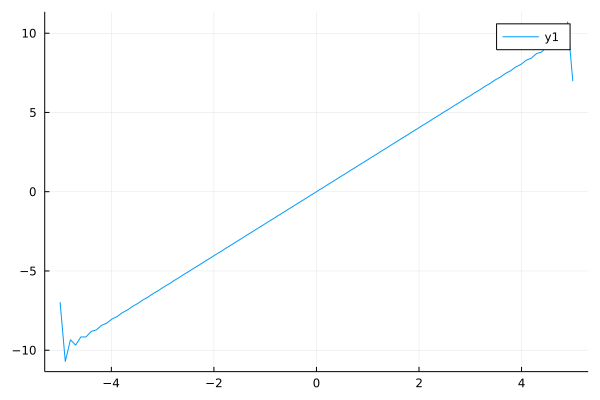

In [13]:
using FFTW
using LinearAlgebra
using Plots
using DSP
ymin = -5.;
ymax = 5.;
xmin = -5.;
xmax = 5.;
N = 100;
Δx = (xmax-xmin)/(N-1);
Δy = (ymax-ymin)/(N-1);
G = zeros(Float64,2,N,N); # meshgrid: deux coordonnées x et y en premier car julia stocke la première dimension de manière contiguë d'abord
ys = ymin:Δy:ymax;        # cf https://discourse.julialang.org/t/meshgrid-function-in-julia/48679/5
xs = xmin:Δx:xmax;
G = zeros(Float64,2,N,N); # on pourrait aussi concaténer, voir https://docs.julialang.org/en/v1/manual/arrays/
G[1,:,:] = ones(N)' .* ys;
G[2,:,:] = xs' .* ones(N);
V = zeros(N,N);
dVdX = zeros(N,N);
X = @view G[1,:,:];
Y = @view G[2,:,:];
f_test = (x,y) -> (x^2 + y^2);
f_te2 = (x,y) -> 2*x;
@. V = f_test(X, Y); # calcul du potentiel sur la grille
@. dVdX = f_te2(X,Y);


V̂ = fft(V[:,1])
κ = fftshift(2*π/(xmax-xmin) * (Vector(Base.OneTo(N)) .- N÷2));
dV̂ = im * κ .* V̂;
∂V = real(ifft(dV̂));
plot(Vector(xs),real(∂V))

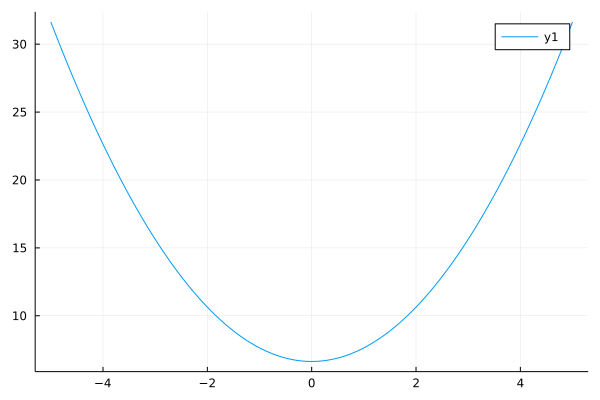

In [10]:
plot(Vector(xs),V[:,25])

In [31]:
V̂ₓ = fft(V, (1,));
κ = fftshift(2*π/(xmax-xmin) * (Vector(Base.OneTo(N)) .- N÷2));
dV̂ₓ = im * κ .* V̂ₓ; # piecewise column-major product
∂V = ifft(dV̂, (1,));

In [17]:
r = ones(5,5)
m = rand(5)

5-element Vector{Float64}:
 0.7758770683598254
 0.7544547241034368
 0.03022334495443335
 0.7975349803608555
 0.841894370147623

In [20]:
g = m .* r

5×5 Matrix{Float64}:
 0.775877   0.775877   0.775877   0.775877   0.775877
 0.754455   0.754455   0.754455   0.754455   0.754455
 0.0302233  0.0302233  0.0302233  0.0302233  0.0302233
 0.797535   0.797535   0.797535   0.797535   0.797535
 0.841894   0.841894   0.841894   0.841894   0.841894

In [23]:
ifft(g, (1,))

5×5 Matrix{ComplexF64}:
  0.639997+0.0im        0.639997+0.0im       …   0.639997+0.0im
  0.119901-0.106835im   0.119901-0.106835im      0.119901-0.106835im
 -0.051961+0.135672im  -0.051961+0.135672im     -0.051961+0.135672im
 -0.051961-0.135672im  -0.051961-0.135672im     -0.051961-0.135672im
  0.119901+0.106835im   0.119901+0.106835im      0.119901+0.106835im

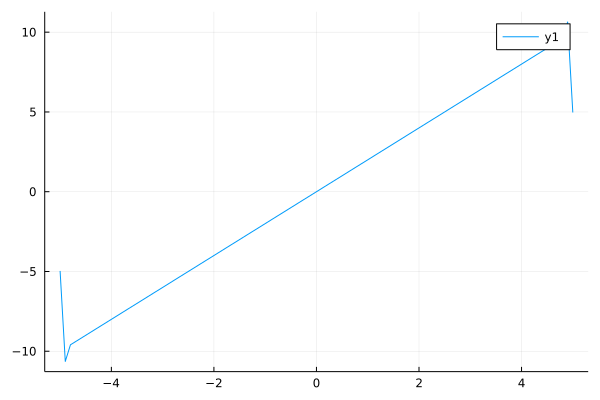

In [12]:
using ImageFiltering

kernel = centered(1/Δx*[+1/12, −2/3,  0.,  2/3, −1/12]);
signal = V[:,1];
plot(xs, imfilter(signal, kernel))




In [4]:
r = rand(10,10)
g = zeros(10,10)
@time g .+= r;
@time g += r;
@time @views g .+= r[:,:];

  0.000013 seconds (2 allocations: 64 bytes)
  0.000009 seconds (1 allocation: 896 bytes)
  0.000051 seconds (5 allocations: 240 bytes)


In [37]:
using BenchmarkTools
x = zeros(10);
@btime x = g[:,5];
@btime @views x = g[:,5];


  206.000 ns (2 allocations: 160 bytes)
  183.934 ns (3 allocations: 80 bytes)


In [ ]:
x = zeros(10);
@btime @views x  += g[:,5];

In [ ]:
function operator_diff1_o8(N, N²)
    O∂1o8 = spzeros(N²,N²);
    B = spzeros(N,N);
    for j in 1:N
        if j<5
          @views B[j,j:j+8]   = diff1_fwd_o8'; # forward  vers ymin
        elseif j>N-4
          @views B[j,j-8:j]   = diff1_bwd_o8'; # backward vers ymax
        else
          @views B[j,j-4:j+4] = diff1_ctr_o8'; # centered elsewhere
        end
    end
    for j in 1:N
        @views O∂1o8[1+(j-1)*N:j*N, 1+(j-1)*N:j*N] .= B;
    end
    return spzeros(O∂1o8)
end

#### Pour comparer la rapidité pour trouver des valeurs popres du hamiltonien en 1D

In [ ]:
@show typeof(Ĥ⁰y)
@show isposdef(Ĥ⁰y)
Ĥ⁰y_m = Matrix(Ĥ⁰y);
Ĥ⁰y_h = Hermitian(Ĥ⁰y_m);
Ĥ⁰y_t = SymTridiagonal(Ĥ⁰y_m);
println("Valeurs propres")
@time eigvals(Ĥ⁰y_m);
@time eigvals(Ĥ⁰y_h);
@time eigvals(Ĥ⁰y_t);
println("Vecteurs propres")
@time eigvecs(Ĥ⁰y_m);
@time eigvecs(Ĥ⁰y_h);
@time eigvecs(Ĥ⁰y_t);